In [2]:
from instrument_classes import EuropeanBasketCallOption
import datetime

#Risk free 3month yield
vol_file = "Rates_Volatilities.xlsx"
from openpyxl import load_workbook
wb = load_workbook(filename=vol_file, data_only=True)
ws = wb["Risk Free"]
r = (ws["F22"].value)/100  # This returns the evaluated result (not the formula)

if r is None:
    raise ValueError("Risk-Free in cell F22 returned None — please check if Excel formula has been calculated and saved.")

wb.close()
print(f"Risk-Free Rate (decimal): {r}")

basket_option = EuropeanBasketCallOption(
    spot_prices=[39.72, 241.82, 21.92, 207.35],
    sigmas=[0.2106, 0.2108, 0.2676, 0.2133],
    correlation_matrix=[
        [1.00, 0.629, 0.569, 0.632],
        [0.629, 1.00, 0.080, 0.498],
        [0.569, 0.080, 1.00, 0.770],
        [0.632, 0.498, 0.770, 1.00]
    ],
    weights=[0.10, 0.35, 0.15, 0.40],
    K=175.00,
    T=(datetime.date(2025, 7, 17) - datetime.date(2025, 5, 16)).days / 365,
    r=r,
    M=100000,
    random_seed=42
)

option_price = basket_option.price()
print(f"European Basket Call Option Price: ${option_price:.2f}")


Risk-Free Rate (decimal): 0.03934
European Basket Call Option Price: $5.73


# Create graph showing Monte Carlo simulations. 

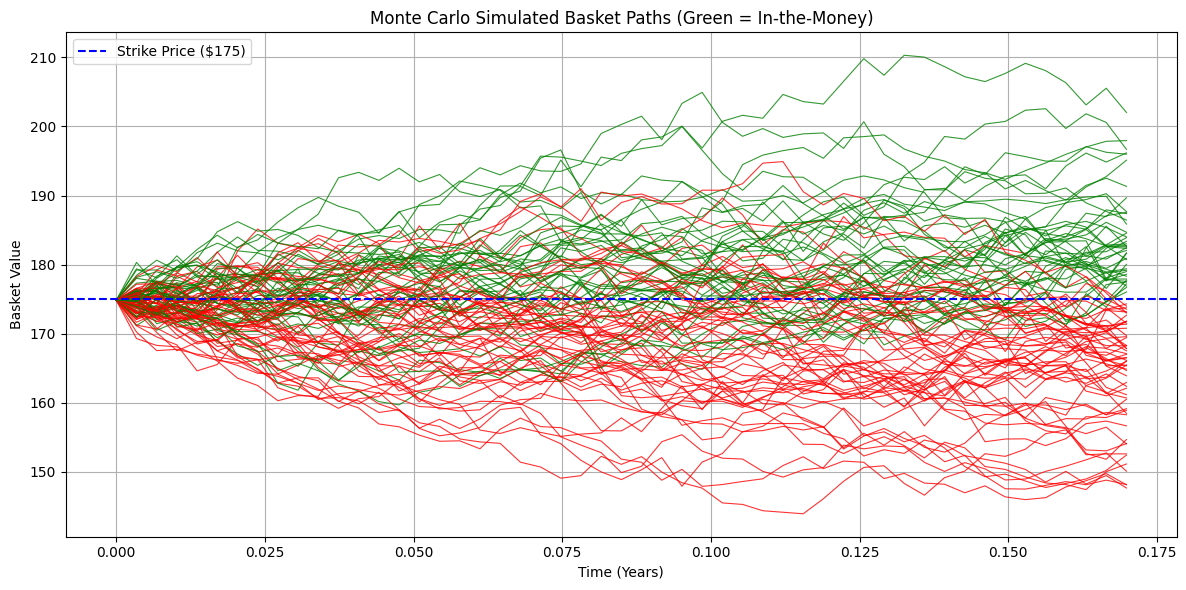

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# === Inputs ===
spot_prices = np.array([39.72, 241.82, 21.92, 207.35])
volatilities = np.array([0.21065, 0.21089, 0.26761, 0.21329])
correlation_matrix = np.array([
    [1.00, 0.629, 0.569, 0.632],
    [0.629, 1.00, 0.080, 0.498],
    [0.569, 0.080, 1.00, 0.770],
    [0.632, 0.498, 0.770, 1.00]
])
weights = np.array([0.10, 0.35, 0.15, 0.40])
r = r
T = 62 / 365  # ~0.1699 years
n_steps = 50
n_paths = 100
strike_price = 175

# === Setup ===
dt = T / n_steps
n_assets = len(spot_prices)
cholesky = np.linalg.cholesky(correlation_matrix)

# === Storage for basket paths ===
basket_paths = np.zeros((n_paths, n_steps + 1))
basket_paths[:, 0] = np.dot(spot_prices, weights)

# === Simulate asset and basket paths ===
current_spots = np.tile(spot_prices, (n_paths, 1))  # shape: (n_paths, n_assets)

for t in range(1, n_steps + 1):
    Z = np.random.normal(size=(n_paths, n_assets))
    correlated_Z = Z @ cholesky.T

    drift = (r - 0.5 * volatilities**2) * dt
    diffusion = volatilities * np.sqrt(dt)

    # Update asset prices for each path
    current_spots *= np.exp(drift + diffusion * correlated_Z)

    # Compute basket value per path
    basket_values = np.dot(current_spots, weights)
    basket_paths[:, t] = basket_values

# === Plotting ===
plt.figure(figsize=(12, 6))
time_grid = np.linspace(0, T, n_steps + 1)

# Color-code paths
for i in range(n_paths):
    final_value = basket_paths[i, -1]
    color = 'green' if final_value > strike_price else 'red'
    plt.plot(time_grid, basket_paths[i], lw=0.8, alpha=0.8, color=color)

# Reference line for strike
plt.axhline(y=strike_price, color='blue', linestyle='--', label="Strike Price ($175)")

plt.title("Monte Carlo Simulated Basket Paths (Green = In-the-Money)")
plt.xlabel("Time (Years)")
plt.ylabel("Basket Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
